Shyju Kozhisseri<br/>ID: 309572<br/>Group: J41323c

## Import Data

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

In [2]:
input = pd.read_csv('garments_worker_productivity.csv')

In [3]:
input.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [4]:
input.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


In [5]:
input.isna().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

In [6]:
sub_sample = input[['date', 'team', 'smv', 'no_of_workers', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'targeted_productivity', 'actual_productivity']]
sub_sample

,date,team,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity
0,1/1/2015,8,26.16,59.0,1108.0,7080,98,0.0,0,0,0.80,0.940725
1,1/1/2015,1,3.94,8.0,NaN,960,0,0.0,0,0,0.75,0.886500
2,1/1/2015,11,11.41,30.5,968.0,3660,50,0.0,0,0,0.80,0.800570
3,1/1/2015,12,11.41,30.5,968.0,3660,50,0.0,0,0,0.80,0.800570
4,1/1/2015,6,25.90,56.0,1170.0,1920,50,0.0,0,0,0.80,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,10,2.90,8.0,NaN,960,0,0.0,0,0,0.75,0.628333
1193,3/11/2015,8,3.90,8.0,NaN,960,0,0.0,0,0,0.70,0.625625
1194,3/11/2015,7,3.90,8.0,NaN,960,0,0.0,0,0,0.65,0.625625
1195,3/11/2015,9,2.90,15.0,NaN,1800,0,0.0,0,0,0.75,0.505889


In [7]:
sub_sample = sub_sample.fillna(sub_sample.mean())
sub_sample.head()

,date,team,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity
0,1/1/2015,8,26.16,59.0,1108.000000,7080,98,0.0,0,0,0.80,0.940725
1,1/1/2015,1,3.94,8.0,1190.465991,960,0,0.0,0,0,0.75,0.886500
2,1/1/2015,11,11.41,30.5,968.000000,3660,50,0.0,0,0,0.80,0.800570
3,1/1/2015,12,11.41,30.5,968.000000,3660,50,0.0,0,0,0.80,0.800570
4,1/1/2015,6,25.90,56.0,1170.000000,1920,50,0.0,0,0,0.80,0.800382


In [8]:
sample = sub_sample.groupby(['team', 'date']).agg({'smv':'sum', 'no_of_workers':'sum', 'wip':'sum', 'over_time':'sum', 'incentive':'sum', 'idle_time':'sum', 'idle_men':'sum', 'no_of_style_change':'sum', 'targeted_productivity':'max','actual_productivity':'mean'})
sample

smv  no_of_workers          wip  over_time  incentive  \
team date                                                                 
1    1/1/2015   32.02           65.5  1871.465991       7860         45   
     1/10/2015  30.10           67.0  2525.465991      12780         63   
     1/11/2015  30.10           67.0  2573.465991      12060         75   
     1/12/2015  30.10           67.0  2289.465991       9660         75   
     1/13/2015  30.10           61.0  2263.465991      12060         75   
...               ...            ...          ...        ...        ...   
12   3/4/2015   19.86           43.0  2151.465991       5160         50   
     3/5/2015   19.86           43.0  2149.465991       5160         50   
     3/7/2015   19.86           43.0  2176.465991       5160         75   
     3/8/2015   19.86           43.0  2254.465991       5160         63   
     3/9/2015   19.86           43.0  2322.465991       4080       1143   

                idle_time  idle_men  no_of_style_change  \
team date                                                 
1    1/1/2015         0.0         0                   0   
     1/10/2015        0.0         0                   0   
     1/11/2015        0.0         0                   0   
     1/12/2015        0.0         0                   0   
     1/13/2015        0.0         0                   0   
...                   ...       ...                 ...   
12   3/4/2015         0.0         0                   0   
     3/5/2015         0.0         0                   0   
     3/7/2015         0.0         0                   0   
     3/8/2015         0.0         0                   0   
     3/9/2015         0.0         0                   0   

                targeted_productivity  actual_productivity  
team date                                                   
1    1/1/2015                    0.75             0.818464  
     1/10/2015                   0.80             0.892559  
     1/11/2015                   0.80             0.861785  
     1/12/2015                   0.80             0.902837  
     1/13/2015                   0.80             0.900961  
...                               ...                  ...  
12   3/4/2015                    0.80             0.843164  
     3/5/2015                    0.80             0.834645  
     3/7/2015                    0.80             0.859705  
     3/8/2015                    0.80             0.872979  
     3/9/2015                    0.80             0.851682  

[701 rows x 10 columns]

## Scale Data

In [9]:
sample.columns

Index(['smv', 'no_of_workers', 'wip', 'over_time', 'incentive', 'idle_time',
       'idle_men', 'no_of_style_change', 'targeted_productivity',
       'actual_productivity'],
      dtype='object')

In [10]:
scaler = MinMaxScaler()
original_data = sample.copy()
sample[['smv', 'no_of_workers', 'wip', 'over_time', 'incentive', 'idle_time','idle_men', 'no_of_style_change']] = scaler.fit_transform(sample[['smv', 'no_of_workers', 'wip', 'over_time', 'incentive', 'idle_time','idle_men', 'no_of_style_change']])
sample

smv  no_of_workers       wip  over_time  incentive  \
team date                                                                 
1    1/1/2015   0.515018       0.713415  0.076710   0.289183   0.012346   
     1/10/2015  0.479853       0.731707  0.103617   0.470199   0.017284   
     1/11/2015  0.479853       0.731707  0.105592   0.443709   0.020576   
     1/12/2015  0.479853       0.731707  0.093908   0.355408   0.020576   
     1/13/2015  0.479853       0.658537  0.092838   0.443709   0.020576   
...                  ...            ...       ...        ...        ...   
12   3/4/2015   0.292308       0.439024  0.088230   0.189845   0.013717   
     3/5/2015   0.292308       0.439024  0.088147   0.189845   0.013717   
     3/7/2015   0.292308       0.439024  0.089258   0.189845   0.020576   
     3/8/2015   0.292308       0.439024  0.092468   0.189845   0.017284   
     3/9/2015   0.292308       0.439024  0.095265   0.150110   0.313580   

                idle_time  idle_men  no_of_style_change  \
team date                                                 
1    1/1/2015         0.0       0.0                 0.0   
     1/10/2015        0.0       0.0                 0.0   
     1/11/2015        0.0       0.0                 0.0   
     1/12/2015        0.0       0.0                 0.0   
     1/13/2015        0.0       0.0                 0.0   
...                   ...       ...                 ...   
12   3/4/2015         0.0       0.0                 0.0   
     3/5/2015         0.0       0.0                 0.0   
     3/7/2015         0.0       0.0                 0.0   
     3/8/2015         0.0       0.0                 0.0   
     3/9/2015         0.0       0.0                 0.0   

                targeted_productivity  actual_productivity  
team date                                                   
1    1/1/2015                    0.75             0.818464  
     1/10/2015                   0.80             0.892559  
     1/11/2015                   0.80             0.861785  
     1/12/2015                   0.80             0.902837  
     1/13/2015                   0.80             0.900961  
...                               ...                  ...  
12   3/4/2015                    0.80             0.843164  
     3/5/2015                    0.80             0.834645  
     3/7/2015                    0.80             0.859705  
     3/8/2015                    0.80             0.872979  
     3/9/2015                    0.80             0.851682  

[701 rows x 10 columns]

In [11]:
sample.describe()

,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,0.399626,0.635347,0.083347,0.286947,0.017900,0.004156,0.014012,0.128388,0.737589,0.729598
std,0.144118,0.156679,0.078371,0.135428,0.057466,0.055313,0.094525,0.267114,0.089539,0.145084
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.350000,0.238042
25%,0.325824,0.597561,0.050935,0.203091,0.008230,0.000000,0.000000,0.000000,0.700000,0.650408
50%,0.413187,0.689024,0.084650,0.280353,0.012346,0.000000,0.000000,0.000000,0.800000,0.751868
75%,0.479853,0.731707,0.097528,0.374172,0.017284,0.000000,0.000000,0.000000,0.800000,0.823032
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,1.060334


## Stationarity Analysis

In [12]:
data = sample.reset_index()
data_1 = data.loc[data['team']==1].set_index('date', drop=True)[['actual_productivity']]
data_1.index = pd.to_datetime(data_1.index)
data_1.sort_index(inplace=True)

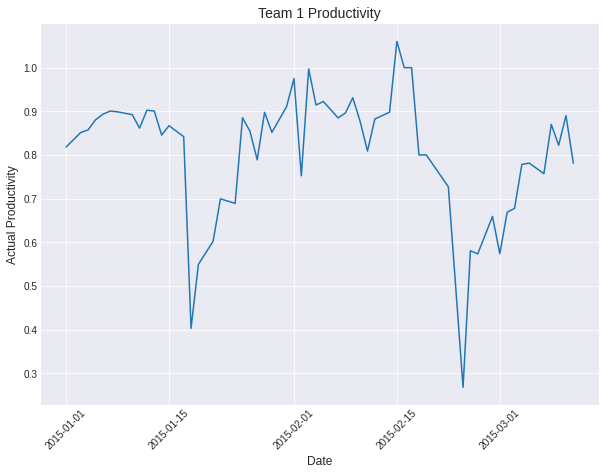

In [13]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 7))
plt.plot(data_1)
plt.title('Team 1 Productivity', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation = 45)
plt.ylabel('Actual Productivity', fontsize=12)
plt.show()

### Moving Mean and Variance Test

In [14]:
split = len(data_1)//2
x1, x2 = data_1[:split], data_1[split:]
print("Mean of the splits are: ", x1.mean()['actual_productivity'], x2.mean()['actual_productivity'])
print("Variance of the splits are: ", x1.var()['actual_productivity'], x2.var()['actual_productivity'])

Mean of the splits are:  0.8241994178571429 0.7963217266896553
Variance of the splits are:  0.016854771770911 0.02637063879399436


### Augmented Dickey-Fuller test

In [15]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# p value<0.05, data does not have a unit root and is stationary

ADF Statistic: -3.478522
p-value: 0.008556
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595


## Covariance and Correlation

In [16]:
sample.cov()

,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity
smv,0.020770,0.014873,0.000851,0.006808,0.000040,0.000120,0.000485,0.004606,-0.000244,-0.001830
no_of_workers,0.014873,0.024548,0.002144,0.010604,0.000595,0.000072,0.000247,0.005272,0.000236,0.002876
wip,0.000851,0.002144,0.006142,0.001186,0.000159,-0.000181,-0.000466,-0.001671,0.000745,0.001590
over_time,0.006808,0.010604,0.001186,0.018341,-0.000238,-0.000147,-0.001420,-0.006683,0.000233,0.001584
incentive,0.000040,0.000595,0.000159,-0.000238,0.003302,-0.000069,-0.000219,-0.000111,0.000178,0.000861
idle_time,0.000120,0.000072,-0.000181,-0.000147,-0.000069,0.003059,0.002916,-0.000401,-0.000421,-0.000943
idle_men,0.000485,0.000247,-0.000466,-0.001420,-0.000219,0.002916,0.008935,0.002802,-0.000440,-0.003148
no_of_style_change,0.004606,0.005272,-0.001671,-0.006683,-0.000111,-0.000401,0.002802,0.071350,-0.005654,-0.010236
targeted_productivity,-0.000244,0.000236,0.000745,0.000233,0.000178,-0.000421,-0.000440,-0.005654,0.008017,0.006538
actual_productivity,-0.001830,0.002876,0.001590,0.001584,0.000861,-0.000943,-0.003148,-0.010236,0.006538,0.021049


In [17]:
sample.corr()

,smv,no_of_workers,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,targeted_productivity,actual_productivity
smv,1.000000,0.658683,0.075315,0.348791,0.004820,0.015097,0.035614,0.119643,-0.018909,-0.087505
no_of_workers,0.658683,1.000000,0.174641,0.499749,0.066124,0.008347,0.016665,0.125982,0.016804,0.126508
wip,0.075315,0.174641,1.000000,0.111780,0.035300,-0.041806,-0.062968,-0.079811,0.106152,0.139814
over_time,0.348791,0.499749,0.111780,1.000000,-0.030573,-0.019557,-0.110945,-0.184754,0.019194,0.080598
incentive,0.004820,0.066124,0.035300,-0.030573,1.000000,-0.021745,-0.040387,-0.007244,0.034501,0.103261
idle_time,0.015097,0.008347,-0.041806,-0.019557,-0.021745,1.000000,0.557725,-0.027141,-0.084927,-0.117466
idle_men,0.035614,0.016665,-0.062968,-0.110945,-0.040387,0.557725,1.000000,0.110962,-0.052004,-0.229559
no_of_style_change,0.119643,0.125982,-0.079811,-0.184754,-0.007244,-0.027141,0.110962,1.000000,-0.236414,-0.264128
targeted_productivity,-0.018909,0.016804,0.106152,0.019194,0.034501,-0.084927,-0.052004,-0.236414,1.000000,0.503294
actual_productivity,-0.087505,0.126508,0.139814,0.080598,0.103261,-0.117466,-0.229559,-0.264128,0.503294,1.000000


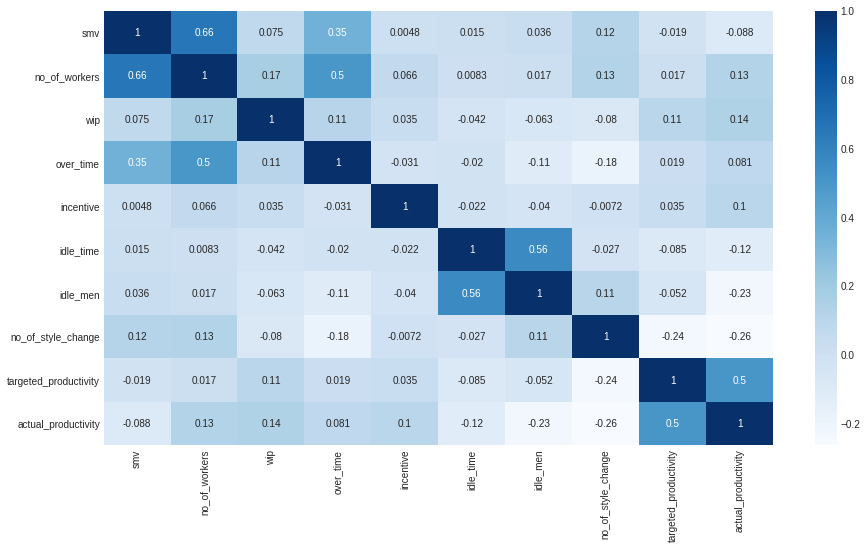

In [18]:
corrMatrix = sample.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corrMatrix, annot=True, cmap='Blues')
plt.show()

## Noise Filtering

In [19]:
data_freq = data_1.asfreq('D', method='ffill')
data_freq_mean = data_freq.resample('W').mean()

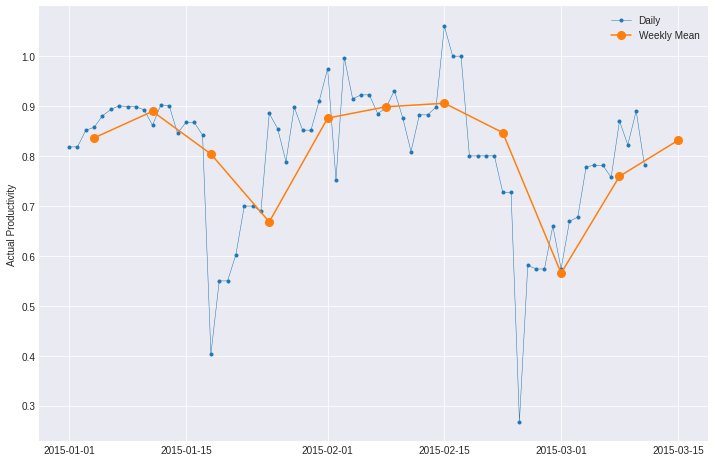

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data_freq['actual_productivity'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(data_freq_mean['actual_productivity'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean')
ax.set_ylabel('Actual Productivity')
ax.legend()

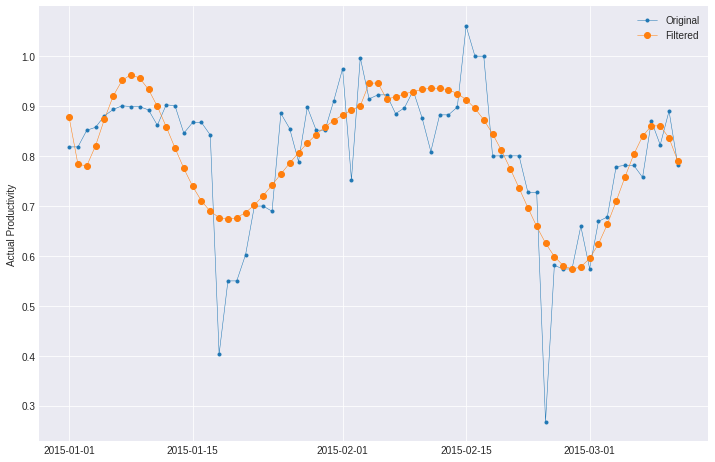

In [21]:
from scipy.signal import savgol_filter
ts = data_freq['actual_productivity']
x = np.arange(0, 70)


n = 10
a = len(ts.index)-1
ts_filter = savgol_filter(ts, a, n)
tsf = pd.Series(ts_filter)
tsf.index = ts.index

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, marker='.', linestyle='-', linewidth=0.5, label='Original')
ax.plot(tsf, marker='o', linestyle='-', linewidth=0.5, label='Filtered')
ax.set_ylabel('Actual Productivity')
ax.legend()


## Spectral Density Function

### Without Filter

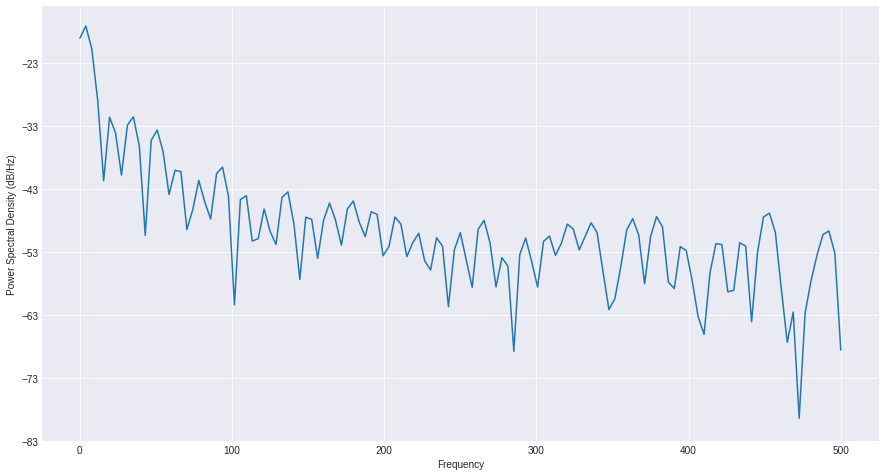

In [22]:
import matplotlib.mlab as mlab

frame_per_second = 1000
fig = plt.figure(figsize=(15, 8))
ax = plt.axes()

sdf = plt.psd(ts, NFFT = 256, Fs = frame_per_second, window = mlab.window_none, scale_by_freq = True)


In [23]:
sdf[0]

array([1.24022694e-02, 1.93674182e-02, 8.47341195e-03, 1.28009154e-03,
       6.82917915e-05, 6.94698844e-04, 3.89020162e-04, 8.37036875e-05,
       5.18826790e-04, 7.03448872e-04, 2.43006534e-04, 9.26036588e-06,
       2.96979709e-04, 4.34668348e-04, 1.97141749e-04, 4.11472206e-05,
       9.94247063e-05, 9.51381346e-05, 1.14859281e-05, 2.38703242e-05,
       6.88135847e-05, 3.16504917e-05, 1.68511191e-05, 8.88167326e-05,
       1.11751670e-04, 3.85434155e-05, 7.29720926e-07, 3.41002241e-05,
       3.94095005e-05, 7.51431112e-06, 8.21435607e-06, 2.42715658e-05,
       1.07352748e-05, 6.64384065e-06, 3.70839467e-05, 4.53368810e-05,
       1.42301362e-05, 1.85275224e-06, 1.79941850e-05, 1.65634844e-05,
       4.00378352e-06, 1.61880543e-05, 3.02028266e-05, 1.61529190e-05,
       6.48286589e-06, 2.42825255e-05, 3.24387418e-05, 1.49794790e-05,
       8.88874348e-06, 2.18848487e-05, 1.99645655e-05, 4.39107534e-06,
       6.16864113e-06, 1.80712426e-05, 1.40054597e-05, 4.24833922e-06,
      

### With filter

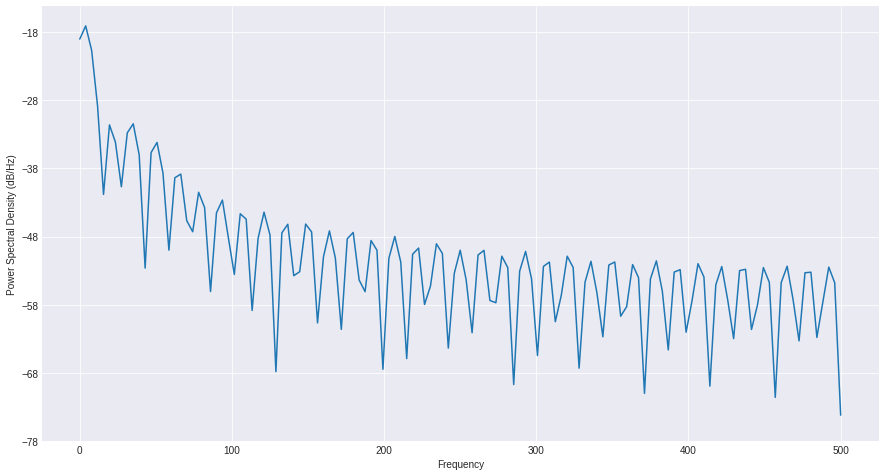

In [24]:
fig = plt.figure(figsize=(15, 8))
ax = plt.axes()

sdf_2 = plt.psd(tsf, NFFT = 256, Fs = frame_per_second, window = mlab.window_none, scale_by_freq = True)


In [25]:
sdf_2[0]

array([1.24275136e-02, 1.94119088e-02, 8.50257951e-03, 1.29121465e-03,
       6.57637895e-05, 6.87019731e-04, 3.84104728e-04, 8.52514959e-05,
       5.25866581e-04, 7.12634941e-04, 2.49846101e-04, 5.47535183e-06,
       2.70121234e-04, 3.80251928e-04, 1.35507514e-04, 1.00286198e-05,
       1.15484238e-04, 1.30568959e-04, 2.71176640e-05, 1.86745935e-05,
       7.06716935e-05, 4.23314231e-05, 2.48140802e-06, 3.53325338e-05,
       5.43745722e-05, 1.52600865e-05, 4.41742319e-06, 3.42309167e-05,
       2.85379770e-05, 1.31243001e-06, 1.49129887e-05, 3.61126597e-05,
       1.68190671e-05, 1.66286288e-07, 1.79879688e-05, 2.40353790e-05,
       4.23772233e-06, 4.84543982e-06, 2.41900498e-05, 1.85711789e-05,
       8.60971545e-07, 8.02518823e-06, 1.92259635e-05, 7.66418881e-06,
       6.92336494e-07, 1.47125033e-05, 1.82227900e-05, 3.66276089e-06,
       2.47178777e-06, 1.38746884e-05, 1.00060003e-05, 1.80245587e-07,
       7.62278726e-06, 1.59301060e-05, 6.72483857e-06, 2.58189082e-07,
      

## Autoregression Model

### On Unfiltered Data

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

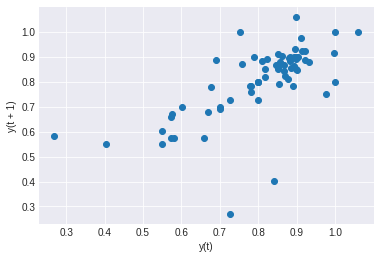

In [26]:
pd.plotting.lag_plot(ts)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

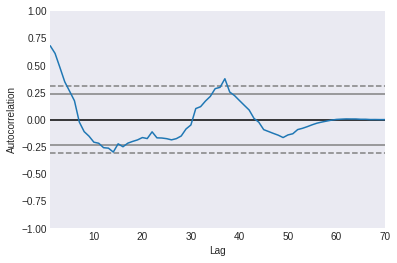

In [27]:
pd.plotting.autocorrelation_plot(ts)

In [28]:
values = pd.DataFrame(ts.values, dtype=np.float64)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
X = dataframe.values
train_size = 50
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model on training set
train_pred = [x for x in train_X]

# residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

# model the training set residuals
window = 15
model = AutoReg(train_resid, lags=window, old_names=True)
model_fit = model.fit()
coef = model_fit.params

history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):

	# persistence
	yhat = test_X[t]
	error = test_y[t] - yhat
	expected_error.append(error)

	# predict error
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	pred_error = coef[0]
	for d in range(window):
		pred_error += coef[d+1] * lag[window-d-1]

    # correct the prediction
	yhat = yhat + pred_error
	predictions.append(yhat)
	history.append(error)
	print('predicted=%f, expected=%f' % (yhat, test_y[t]))
# error
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=0.771630, expected=0.800471
predicted=0.848464, expected=0.800471
predicted=0.783124, expected=0.727350
predicted=0.761605, expected=0.727350
predicted=0.805171, expected=0.268214
predicted=0.458246, expected=0.581131
predicted=0.519834, expected=0.573871
predicted=0.618927, expected=0.573871
predicted=0.581907, expected=0.659598
predicted=0.692473, expected=0.574371
predicted=0.625934, expected=0.669249
predicted=0.740114, expected=0.677998
predicted=0.746028, expected=0.778765
predicted=0.610984, expected=0.781638
predicted=0.856245, expected=0.781638
predicted=0.780154, expected=0.757460
predicted=0.725662, expected=0.870337
predicted=0.902891, expected=0.822497
predicted=0.816124, expected=0.890408
predicted=0.773831, expected=0.781338
Test RMSE: 0.143


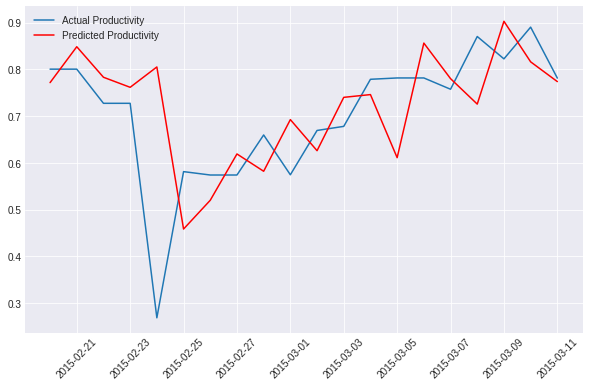

In [29]:
# plot predicted error
plt.figure(figsize=(10, 6))
dt = ts[len(ts)-20:].index.values
plt.plot(dt, test_y, label = 'Actual Productivity')
plt.plot(dt, predictions, color='red', label='Predicted Productivity')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [30]:
print("Model Degrees of Freedom: ",model.df_model)

Model Degrees of Freedom:  16


### On filtered Data

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

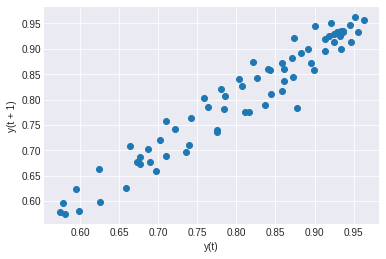

In [31]:
pd.plotting.lag_plot(tsf)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

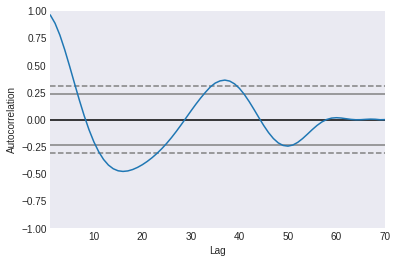

In [32]:
pd.plotting.autocorrelation_plot(tsf)

In [33]:
values = pd.DataFrame(tsf.values, dtype=np.float64)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
X = dataframe.values
train_size = 50
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model on training set
train_pred = [x for x in train_X]

# residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

# model the training set residuals
window = 15
model = AutoReg(train_resid, lags=window, old_names=True)
model_fit = model.fit()
coef = model_fit.params

history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):

	# persistence
	yhat = test_X[t]
	error = test_y[t] - yhat
	expected_error.append(error)

	# predict error
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	pred_error = coef[0]
	for d in range(window):
		pred_error += coef[d+1] * lag[window-d-1]

    # correct the prediction
	yhat = yhat + pred_error
	predictions.append(yhat)
	history.append(error)
	print('predicted=%f, expected=%f' % (yhat, test_y[t]))
# error
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=0.801266, expected=0.774849
predicted=0.746711, expected=0.735933
predicted=0.708946, expected=0.696627
predicted=0.669652, expected=0.659092
predicted=0.633793, expected=0.625689
predicted=0.603873, expected=0.598819
predicted=0.582318, expected=0.580742
predicted=0.571265, expected=0.573357
predicted=0.572323, expected=0.577967
predicted=0.586334, expected=0.595049
predicted=0.613130, expected=0.624029
predicted=0.651338, expected=0.663114
predicted=0.698231, expected=0.709188
predicted=0.749690, expected=0.757830
predicted=0.800301, expected=0.803491
predicted=0.843648, expected=0.839883
predicted=0.872859, expected=0.860660
predicted=0.881483, expected=0.860446
predicted=0.864772, expected=0.836309
predicted=0.821459, expected=0.789783
Test RMSE: 0.014


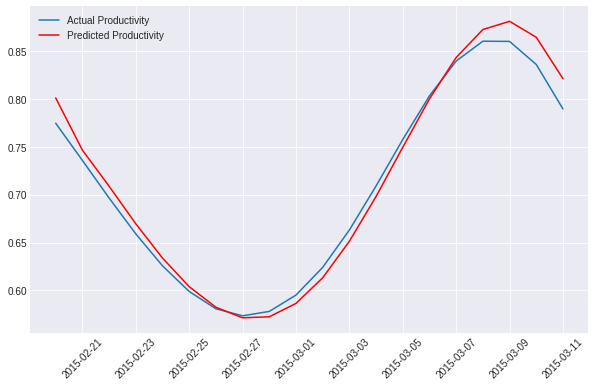

In [34]:
plt.figure(figsize=(10, 6))
dt = tsf[len(tsf)-20:].index.values
plt.plot(dt, test_y, label = 'Actual Productivity')
plt.plot(dt, predictions, color='red', label='Predicted Productivity')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [35]:
print("Model Degrees of Freedom: ",model.df_model)

Model Degrees of Freedom:  16


## Model as a Linear Dynamical System